# Compling the cross-validation datasets

[Prev](./240615-1-complie-main.ipynb): Compile the main dataset

Preprocessing:
- OGs: filter out "rare" orthologs to let Markov-modulation focus on the global evolutionary trends
- tree: branch length adjustment (using MP)

In [1]:
import gzip, json

import numpy as np
import pandas as pd
from ete3 import Tree

from colaml import *
from colaml.misc.dataplot import draw_extant
from colaml.misc.parsimony import mean_mp_changes
from myconfig import DATASET_DIR

In [2]:
from threadpoolctl import threadpool_limits
threadpool_limits(1, user_api='blas')

In [3]:
with gzip.open(DATASET_DIR/'02-bacteria'/'bacteria-main-v0.json.gz') as file:
    data = json.load(file)

In [4]:
# Define an otholog as "rare" if only 5% or less of species have it.
rawOGs = pd.DataFrame(**data['OGs'])
filtOGs = rawOGs.loc[:, rawOGs.ne(0).sum(axis=0) > len(rawOGs) * 0.05]
filtOGs

,COG0001,COG0002,COG0003,COG0004,COG0005,COG0006,COG0007,COG0009,COG0010,COG0011,...,COG5642,COG5646,COG5649,COG5650,COG5652,COG5653,COG5658,COG5660,COG5662,COG5663
n12,3,1,1,3,2,2,1,1,0,0,...,0,0,0,0,0,2,0,0,0,0
n256,0,1,0,2,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
n257,1,1,0,2,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
n204,1,1,0,2,1,1,2,2,1,0,...,0,0,0,0,0,0,0,0,0,0
n88,2,1,0,3,2,1,2,1,1,0,...,0,0,0,0,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n69,1,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,2,0,0,0
n153,2,2,1,1,2,2,1,1,2,0,...,0,1,0,1,0,1,0,0,1,0
n84,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n7,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


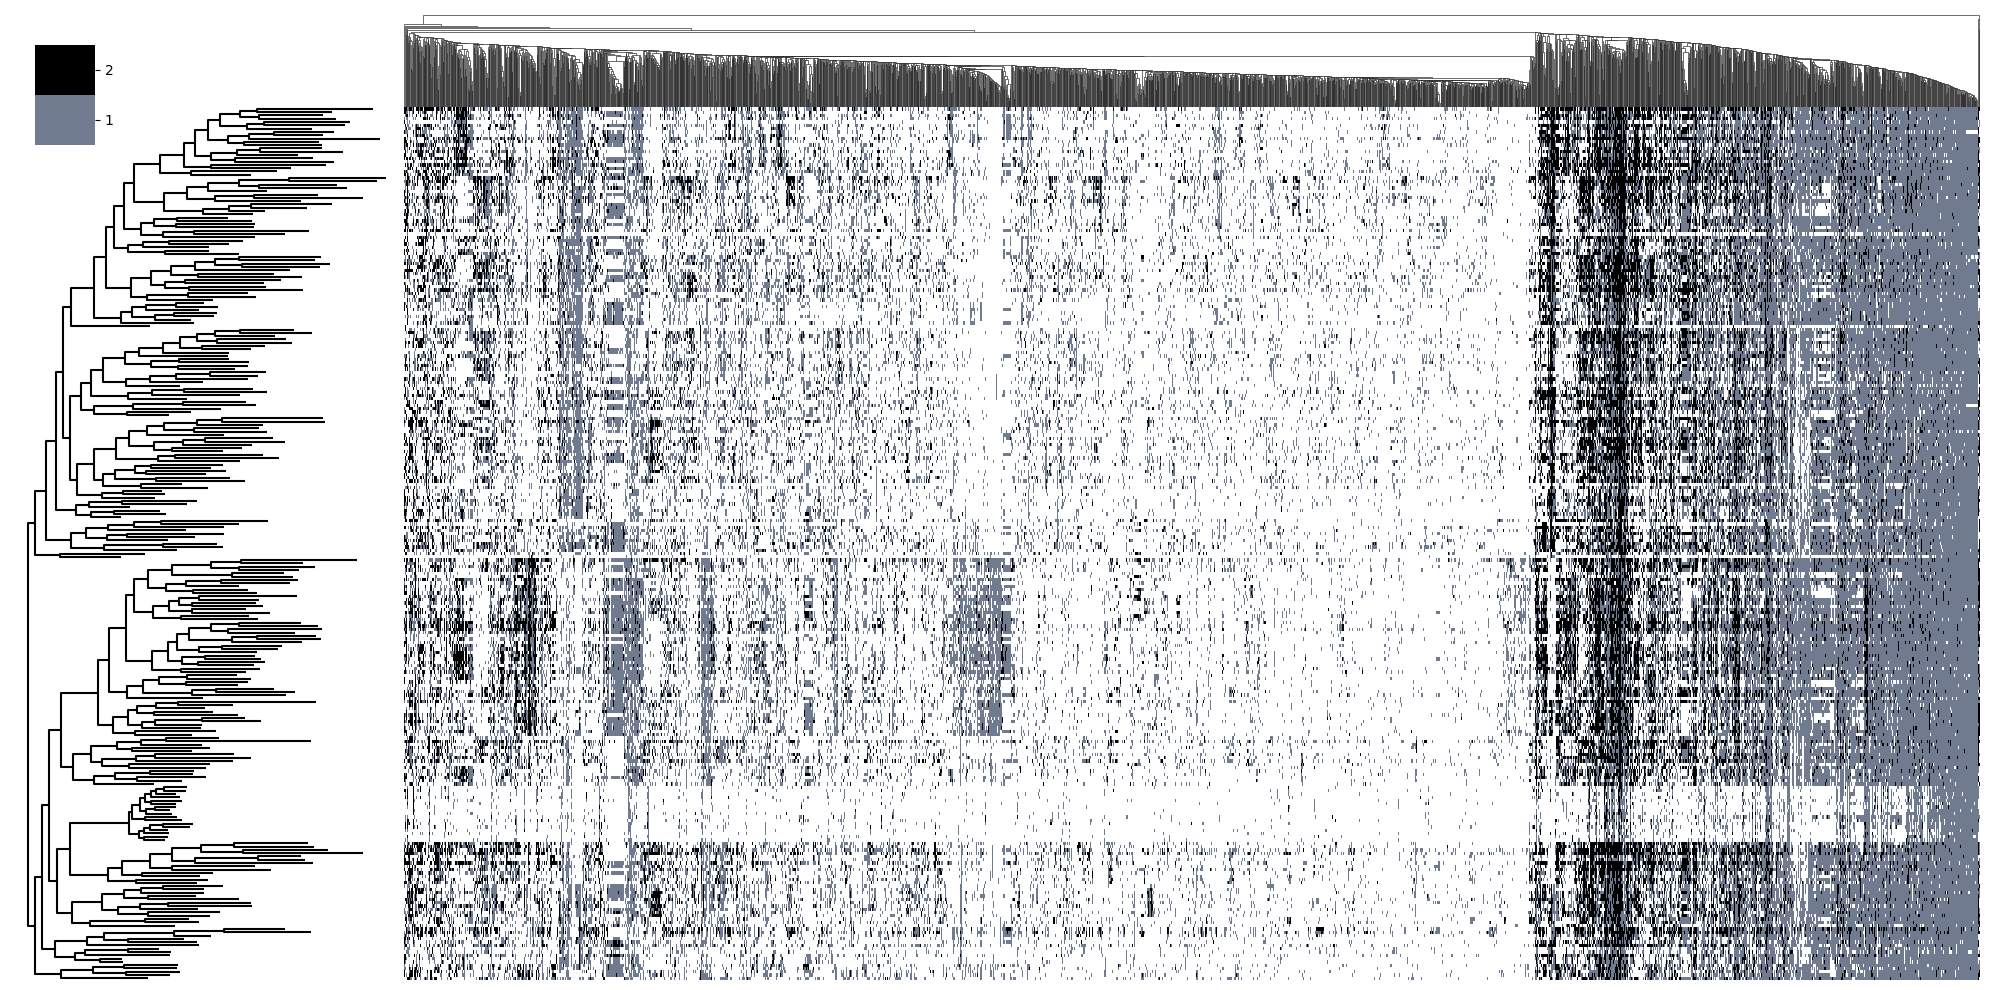

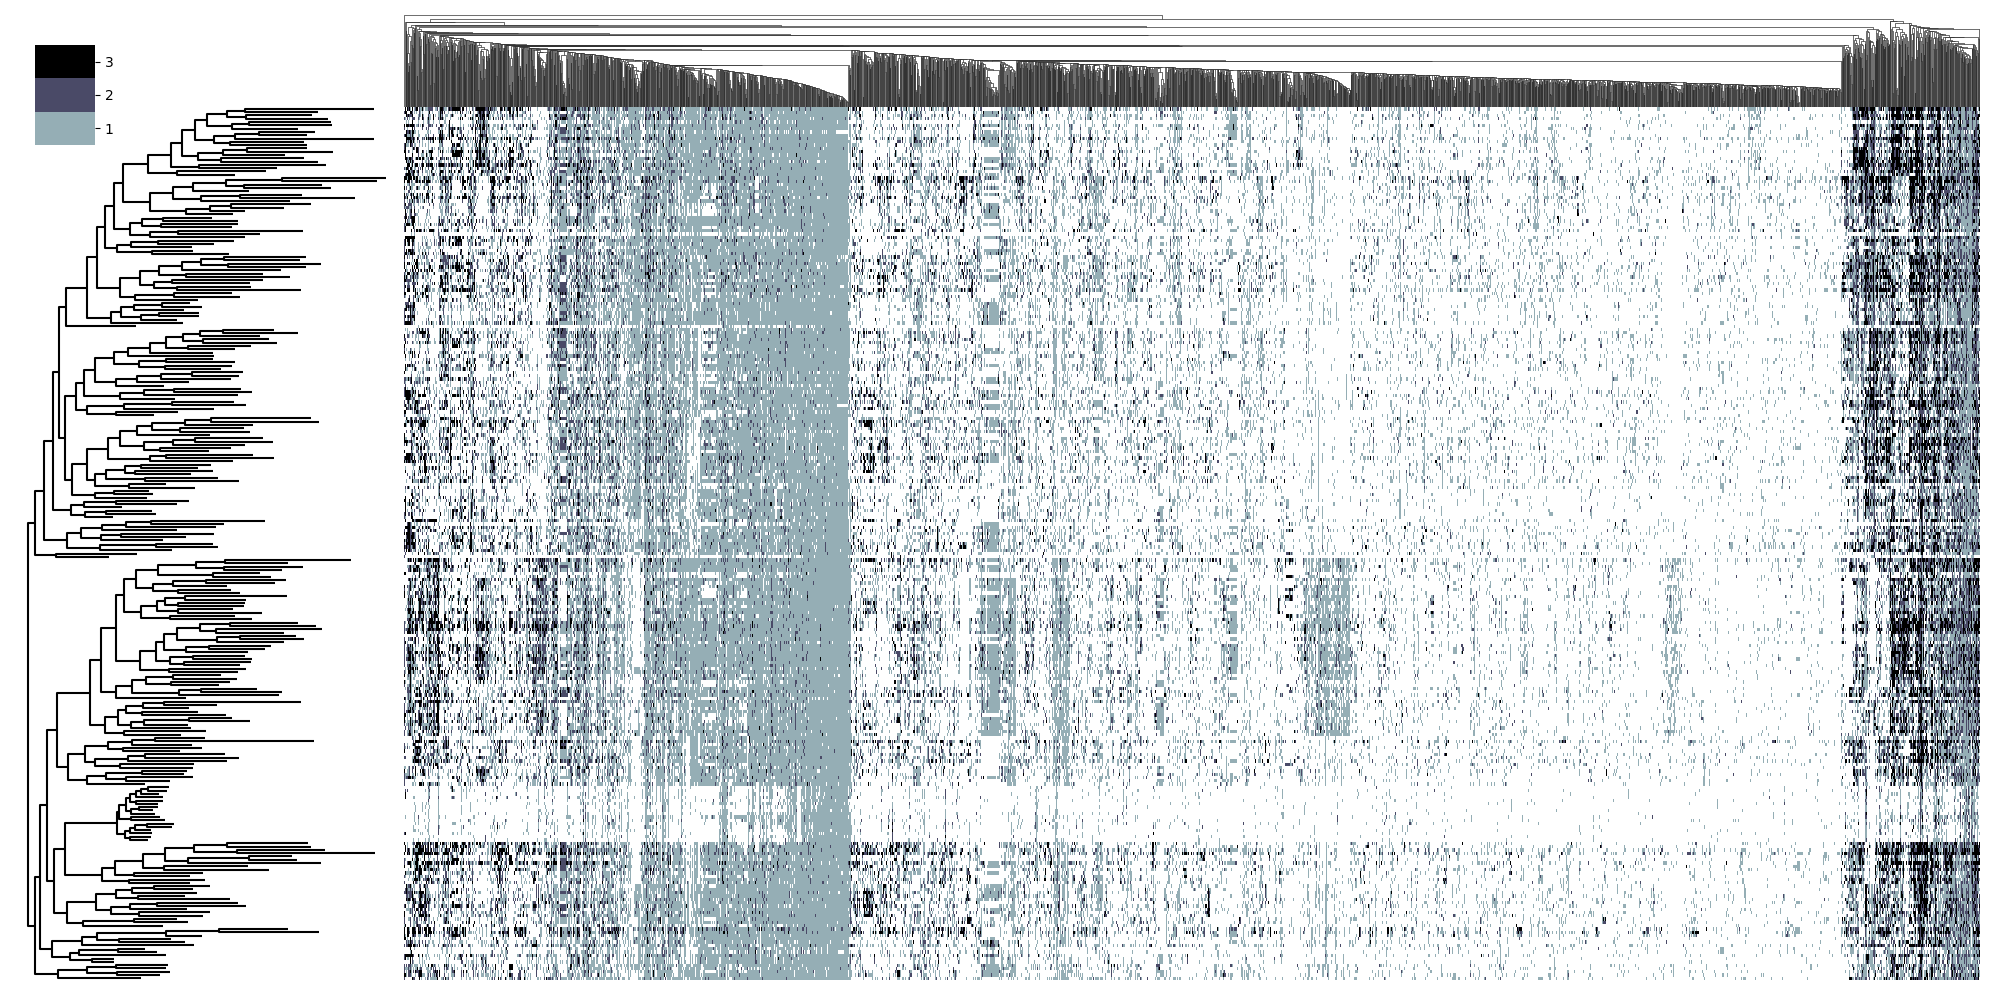

In [5]:
FOLD = 5
seed = 812674781259785

for lmax in (2, 3):
    OGs = filtOGs.clip(0, lmax)
    tindex = PostorderSerializedTree(Tree(data['tree'], format=3))
    phytbl = ExtantPhyTable(OGs.T.to_dict(orient='list'), tindex)
    
    # adjust branch length with mean MP
    phytbl.tree.branch_lengths = mean_mp_changes(phytbl).mean(axis=1)
    draw_extant(phytbl)
    
    tree_str = Tree.write(phytbl.tree.to_ete3(), format=3, format_root_node=True)
    
    rng = np.random.default_rng([lmax, seed])
    for i, test_cols in enumerate(np.array_split(rng.permutation(OGs.columns), FOLD), start=1):
        train = OGs.drop(columns=test_cols)
        test  = OGs[test_cols].sort_index(axis=1)
    
        OUT_DIR = DATASET_DIR/'02-bacteria'/'cv5'
        
        with gzip.open(OUT_DIR/f'bacteria-lmax{lmax}-train{i}-v0.json.gz', 'wt') as file:
            json.dump({
                'tree': tree_str,
                'OGs' : train.to_dict(orient='split')
            }, file, indent=2)

        with gzip.open(OUT_DIR/f'bacteria-lmax{lmax}-test{i}-v0.json.gz', 'wt') as file:
            json.dump({
                'tree': tree_str,
                'OGs' : test.to_dict(orient='split')
            }, file, indent=2)
    